In [1]:
import os

import numpy as np
import pandas as pd

from analysis import isovisc, utilities, common
reader = isovisc.data.reader
from everest.h5anchor import Fetch, Scope
from everest.window import Canvas, plot, raster, DataChannel as Channel, get_cmap
%matplotlib inline

In [2]:
inputs, initials, finals, averages = isovisc.data.get_summary_frames()

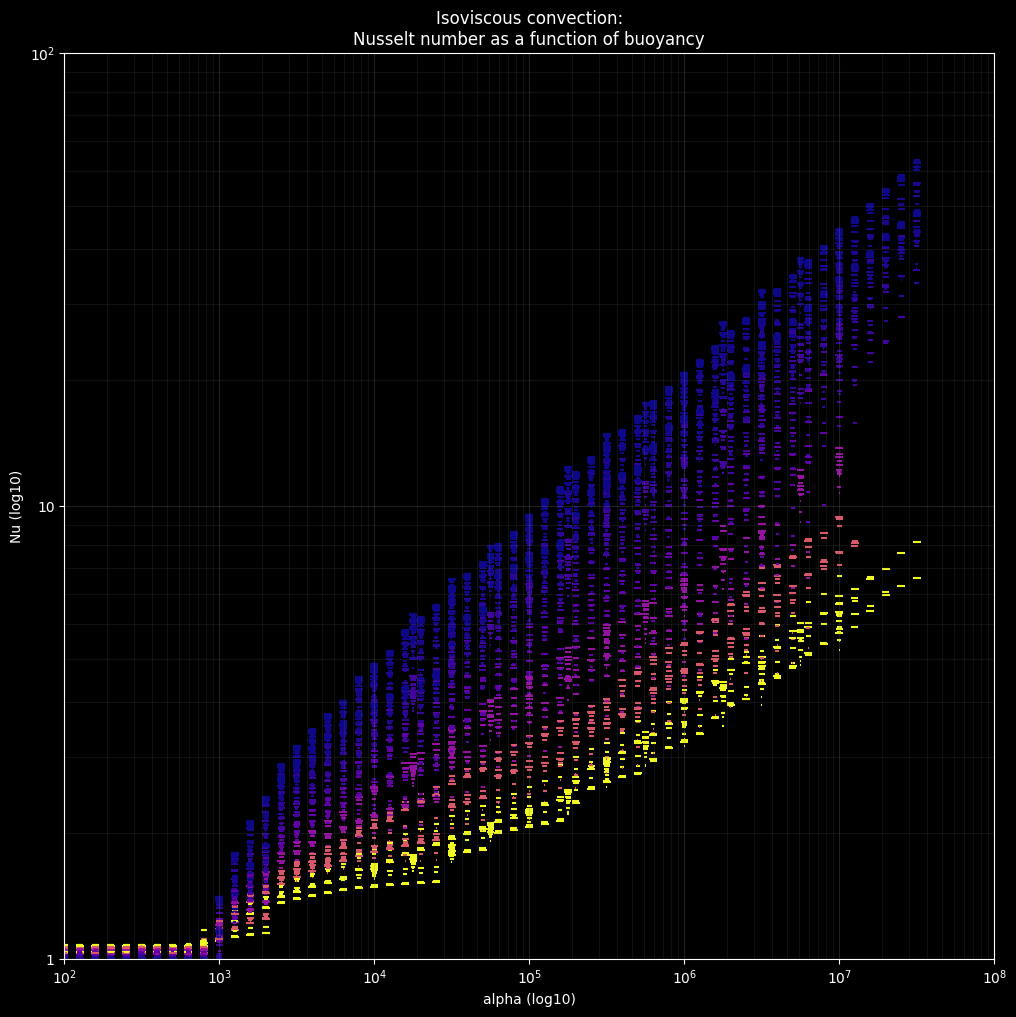

In [3]:
canvas = Canvas(size = (12, 12), fill = 'black', colour = 'white')
ax = canvas.make_ax(title = 'Isoviscous convection:\nNusselt number as a function of buoyancy')
ax.scatter(
    x := Channel(inputs['alpha'], label = 'alpha', lims = (None, None), capped = (True, None), islog = True),
    y := Channel(averages['Nu'], label = 'Nu', lims = (0, None), capped = (True, None), log = True),
    30 * (2 * inputs['f'] - 1) + 1,
    c = inputs['H'],
    marker = "_",
    cmap = 'plasma',
    )
canvas.show()

In [4]:
def get_maxres_indices(inputs):
    '''Get hashIDs of only those models which equal the max resolution available for those parameters.'''
    effkeys = [key for key in inputs.columns if not key in {'res', 'temperatureField'}]
    mygrp = inputs.groupby(effkeys)
    maxres = mygrp['res'].apply(max)
    reind = inputs.reset_index().set_index(effkeys)
    reind['maxres'] = maxres
    selection = reind.loc[reind['res'] == reind['maxres']]['hashID']
    return selection

In [98]:
selection = inputs.loc[get_maxres_indices(inputs)]
selection = dict(list(selection.groupby(['H', 'aspect'])))[0, 1]
selection = selection.loc[selection['alpha'] >= 4]

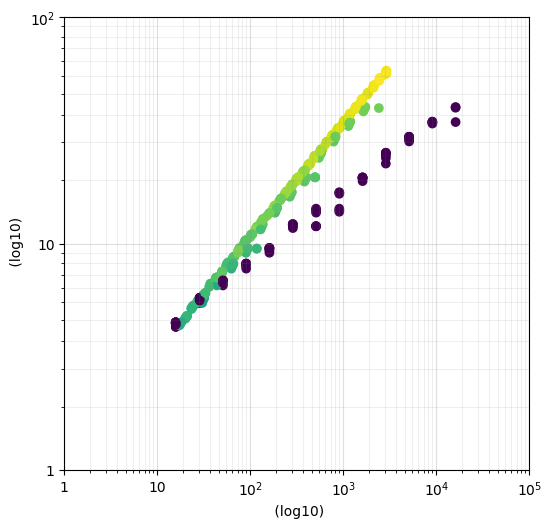

In [49]:
plot.scatter(
    Channel(initials.loc[selection.index]['psi_range'], log = True),
    Channel(averages.loc[selection.index]['Nu'], log = True),
    c = Channel(initials.loc[selection.index]['theta_range']),
    size = (6, 6)
    )

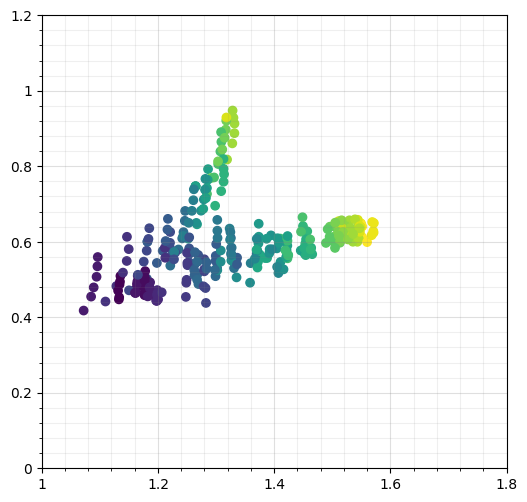

In [105]:
plot.scatter(
    Channel(initials.loc[selection.index]['theta_range']),
    Channel(initials.loc[selection.index]['Nu_min']),
    c = Channel(inputs.loc[selection.index]['alpha']),
    size = (6, 6)
    )

In [102]:
selection = inputs.loc[get_maxres_indices(inputs)]
selection = dict(list(selection.groupby(['H', 'aspect'])))[0, 1]
selection = selection.loc[selection['alpha'] >= 4]
# selection = (selinit := initials.loc[selection.index]).loc[selinit['psi_av'] > -2000]
selection = selection.loc[(selinit := initials.loc[selection.index]).loc[selinit['theta_range'] > 1].index]
selection = selection.loc[initials.loc[selection.index]['theta_range'] > 1]
selection = selection.loc[initials.loc[selection.index]['Nu_min'] < 2]

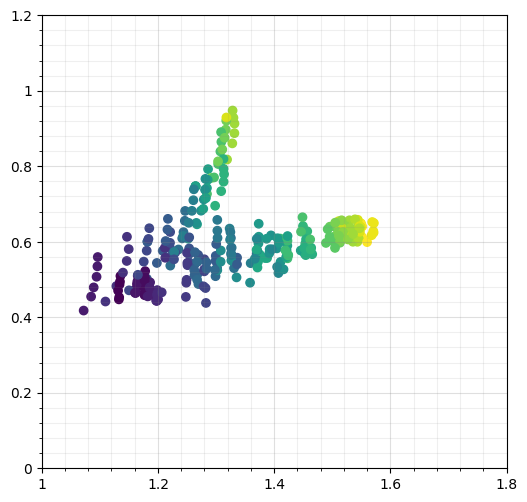

In [109]:
plot.scatter(
    Channel(initials.loc[selection.index]['theta_range']),
    Channel(initials.loc[selection.index]['Nu_min']),
    c = Channel(inputs.loc[selection.index]['alpha']),
    size = (6, 6)
    )

In [110]:
def linear2_fineres(alphaexp):
    return max(8, round(2 ** alphaexp / 4) * 4)

In [112]:
inputs['res'] == inputs['alpha'].apply(linear2_fineres)

hashID
iudruiejoe-wospdreabl      True
rhoftsuad-kleatzeetsou     True
iaseasfiong-sariungee      True
snoikreopsuu-remsneaj     False
beinadwe-griaeafui         True
                          ...  
psovsceugh-smiagldwots    False
usniaqoish-snuothciay     False
kraaskuesaa-haklakrie     False
ougheaazi-sneaslyeasl     False
kweubreothee-uadoelear     True
Length: 8984, dtype: bool

In [115]:
(selinps := inputs.loc[selection.index]).loc[selinps['res'] == selinps['alpha'].apply(linear2_fineres)]

,H,alpha,aspect,f,res,temperatureField
hashID,,,,,,
rhoftsuad-kleatzeetsou,0.0,4.4,1.0,0.80,20.0,_built_hoeklzhiawr-kluactruuj
uodwueoutwia-freibiuflo,0.0,5.2,1.0,0.85,36.0,_built_draitwsfoich-eigheeeoploo
phootheimoa-wiarhliogh,0.0,7.2,1.0,0.55,148.0,_built_eesliudweex-cifluubrao
gluifrquasp-liengsheidw,0.0,5.0,1.0,0.50,32.0,_built_oasuoghuofl-uozhoostats
fointzaikl-scuescdwiah,0.0,7.0,1.0,0.80,128.0,_built_sweikwiisma-pluujsoosl
...,...,...,...,...,...,...
praiklbluusp-roangveafr,0.0,7.4,1.0,0.55,168.0,_built_chouklkefl-gluphwuogr
eoskiuzu-ouxaeaisnoo,0.0,7.0,1.0,0.60,128.0,_built_aisniebrigl-twiavaoqu
woasnstuifr-xuvaavea,0.0,5.5,1.0,0.85,44.0,_built_groghsauch-eanioneabr


In [116]:
selection = inputs.loc[get_maxres_indices(inputs)]
selection = dict(list(selection.groupby(['H', 'aspect'])))[0, 1]
selection = selection.loc[selection['alpha'] >= 4]
# selection = (selinit := initials.loc[selection.index]).loc[selinit['psi_av'] > -2000]
selection = selection.loc[(selinit := initials.loc[selection.index]).loc[selinit['theta_range'] > 1].index]
selection = selection.loc[initials.loc[selection.index]['theta_range'] > 1]
selection = selection.loc[initials.loc[selection.index]['Nu_min'] < 2]
selection = selection.loc[
    (selinps := inputs.loc[selection.index]).loc[selinps['res'] == selinps['alpha'].apply(linear2_fineres)].index
    ]
selection = selection.index

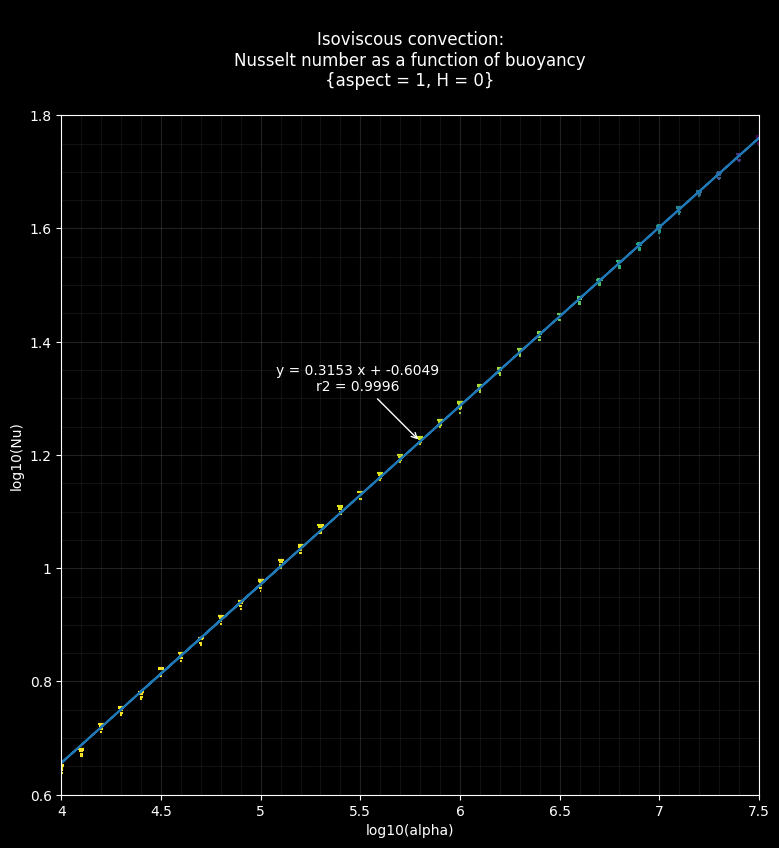

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

selection = inputs.loc[get_maxres_indices(inputs)]
selection = dict(list(selection.groupby(['H', 'aspect'])))[0, 1]
selection = selection.loc[selection['alpha'] >= 4]
# selection = (selinit := initials.loc[selection.index]).loc[selinit['psi_av'] > -2000]
selection = selection.loc[(selinit := initials.loc[selection.index]).loc[selinit['theta_range'] > 1].index]
selection = selection.loc[initials.loc[selection.index]['theta_range'] > 1]
selection = selection.loc[initials.loc[selection.index]['Nu_min'] < 2]
selection = selection.loc[
    (selinps := inputs.loc[selection.index]).loc[selinps['res'] == selinps['alpha'].apply(linear2_fineres)].index
    ]
selection = selection.index

linreg = LinearRegression().fit(
    x := inputs.loc[selection]['alpha'].to_numpy().reshape(-1, 1),
    y := averages.loc[selection]['Nu'].apply(np.log10),
    )
pred = linreg.predict(x)
r2 = r2_score(y, pred)
slope, intercept = linreg.coef_, linreg.intercept_

canvas = Canvas(size = (9, 9), fill = 'black', colour = 'white')

title = '''
Isoviscous convection:
Nusselt number as a function of buoyancy
{aspect = 1, H = 0}
'''

ax = canvas.make_ax(title = title)
ax.scatter(
    Channel(inputs.loc[selection]['alpha'], label = 'log10(alpha)', lims = (4, 7.5), capped = (True, None)),
    Channel(np.log10(averages.loc[selection]['Nu']), label = 'log10(Nu)', lims = (0.6, 1.8), capped = (True, None)),
    20 * (2 * inputs.loc[selection]['f'] - 1) + 1,
    c = initials.loc[selection]['psi_av'],
    marker = "_",
    cmap = 'viridis',
    )
ax.line(x, pred)
# slopeformat = "{:.2e}".format(slope[0])
label = f"y = {round(float(slope), 4)} x + {round(intercept, 4)}\nr2 = {round(r2, 4)}"
ax.annotate(
    *list(zip(x, pred))[round(len(pred) / 2)],
    label,
    points = (-45, 45),
    arrowProps = {'arrowstyle': '->', 'color': 'white'},
    color = 'white'
    )
canvas.show()

In [119]:
def jarvis_geom(f):
    f = 0.999 if f >= 1 else f
    return -np.log(f) / ((1 - f) * (1 + f ** (-3 / 4)) ** (4 / 3))
jarv = inputs['f'].apply(jarvis_geom)

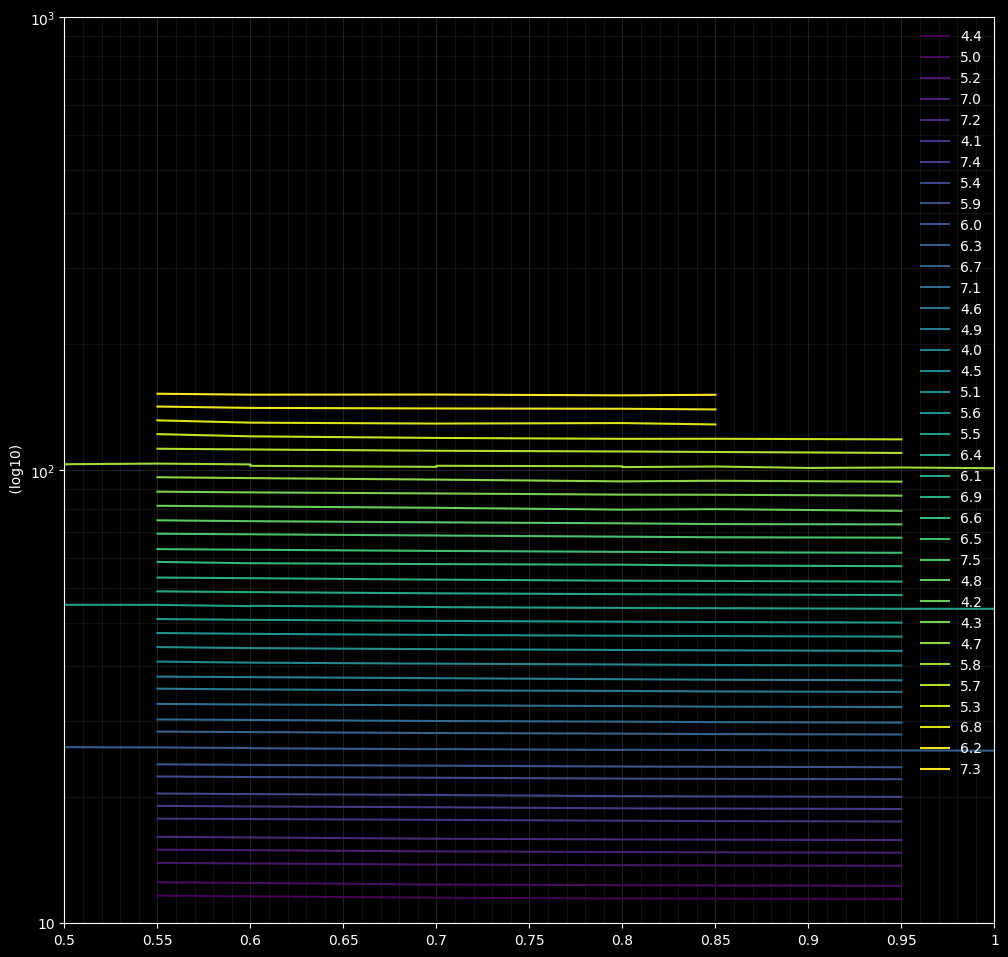

In [124]:
canvas = Canvas(size = (12, 12), colour = 'white', fill = 'black')
ax = canvas.make_ax()
cmap = get_cmap('viridis')
alphas = list(set(inputs.loc[selection]['alpha']))
def colour(val, vals, cmap):
    return cmap((val - min(vals)) / (max(vals) - min(vals)))
for alpha, subfrm in inputs.groupby('alpha'):
    subsel = sorted(set.intersection(set(selection), set(subfrm.index)))
    if subsel:
        fs = inputs.loc[subsel]['f'].sort_values()
        ax.line(
            fs,
            Channel(averages.loc[fs.index]['Nu'] / jarv.loc[fs.index], lims = (1, None), capped = (True, None), log = True),
            c = colour(alpha, alphas, cmap),
            )
ax.props.legend.set_handles_labels(
    (row[0] for row in ax.collections),
    alphas,
    )
canvas.show()

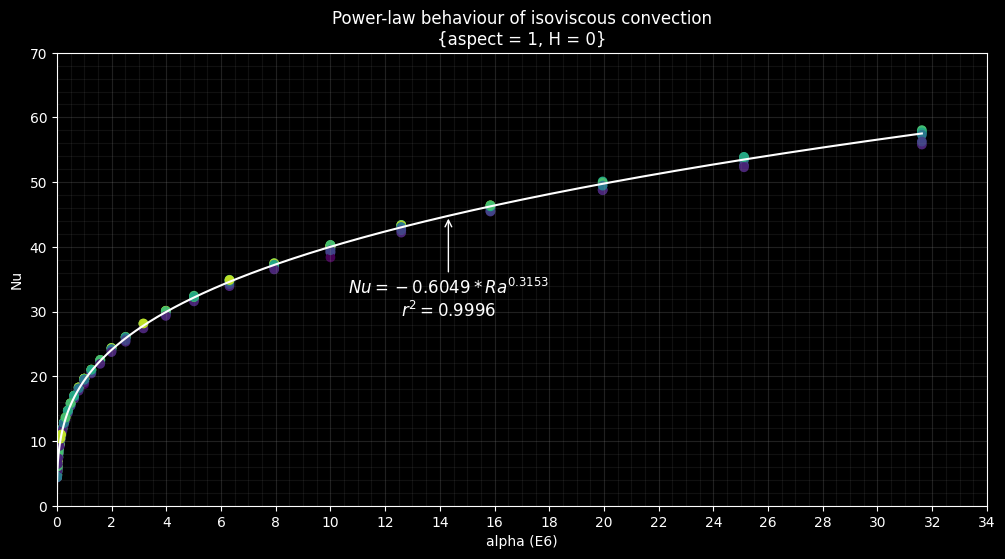

In [125]:
canvas = Canvas(size = (12, 6), colour = 'white', fill = 'black', dpi = 100)
ax = canvas.make_ax(
    title = 'Power-law behaviour of isoviscous convection\n{aspect = 1, H = 0}',
    )
ax.scatter(
    Channel(
        x := 10 ** inputs.loc[selection]['alpha'].to_numpy(),
        label = 'alpha',
        ),
    Channel(
        y := averages.loc[selection]['Nu'],
        label = 'Nu',
#         lims = (1, 2.2),
        capped = (True, None),
        ),
    c = inputs.loc[selection]['f']
    )

linreg = LinearRegression().fit(
    xlin := np.log10(x).reshape(-1, 1),
    ylin := np.log10(y),
    )
pred = linreg.predict(xlin)
r2 = r2_score(ylin, pred)
slope, intercept = linreg.coef_, linreg.intercept_

ax.line(
    x := np.arange(1, max(x), 1e3),
    y := 10 ** linreg.predict(np.log10(x).reshape(-1, 1)),
    color = 'white'
    )
# slopeformat = "{:.2e}".format(slope[0])
stint, stslo, str2 = (str(arg) for arg in (round(intercept, 4), round(float(slope), 4), round(r2, 4)))
label = r"$Nu = " + stint + r"*Ra^{" + stslo + r"}$" + '\n' + r"$r^{2} = " + str2 + r"$"
# label = f"Nu_j = {} Ra ^ {}\nr2 = "
ax.annotate(
    *list(zip(x, y))[round(len(y) / 2) - 1500],
    label,
    points = (0, -60),
    arrowProps = {'arrowstyle': '->', 'color': 'white'},
    color = 'white',
    fontsize = 12,
    )

canvas.show()

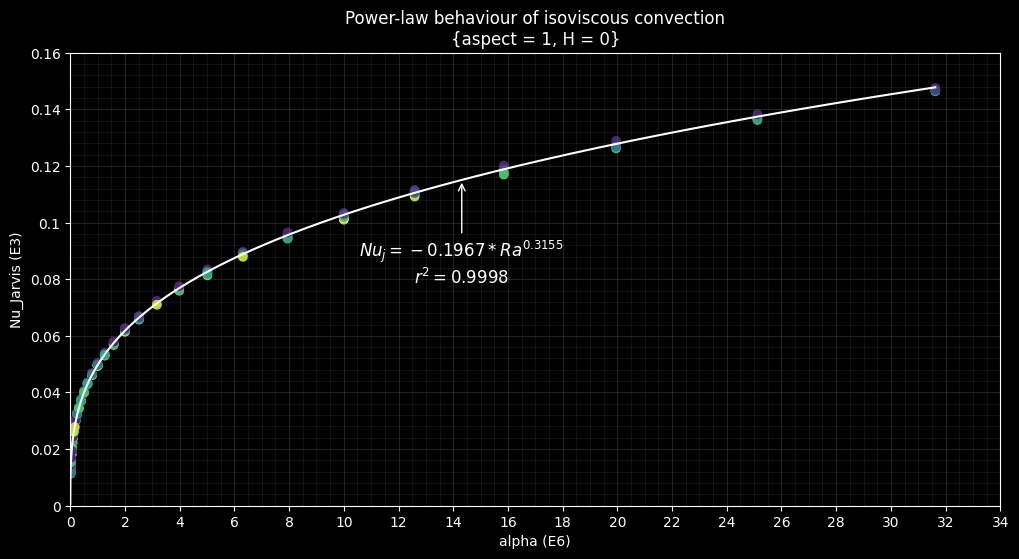

In [126]:
canvas = Canvas(size = (12, 6), colour = 'white', fill = 'black', dpi = 100)
ax = canvas.make_ax(
    title = 'Power-law behaviour of isoviscous convection\n{aspect = 1, H = 0}',
    )
ax.scatter(
    Channel(
        x := 10 ** inputs.loc[selection]['alpha'].to_numpy(),
        label = 'alpha',
        ),
    Channel(
        y := averages.loc[selection]['Nu'] / jarv.loc[selection],
        label = 'Nu_Jarvis',
#         lims = (1, 2.2),
        capped = (True, None),
        ),
    c = inputs.loc[selection]['f']
    )

linreg = LinearRegression().fit(
    xlin := np.log10(x).reshape(-1, 1),
    ylin := np.log10(y),
    )
pred = linreg.predict(xlin)
r2 = r2_score(ylin, pred)
slope, intercept = linreg.coef_, linreg.intercept_

ax.line(
    x := np.arange(1, max(x), 1e3),
    y := 10 ** linreg.predict(np.log10(x).reshape(-1, 1)),
    color = 'white'
    )
# slopeformat = "{:.2e}".format(slope[0])
stint, stslo, str2 = (str(arg) for arg in (round(intercept, 4), round(float(slope), 4), round(r2, 4)))
label = r"$Nu_{j} = " + stint + r"*Ra^{" + stslo + r"}$" + '\n' + r"$r^{2} = " + str2 + r"$"
# label = f"Nu_j = {} Ra ^ {}\nr2 = "
ax.annotate(
    *list(zip(x, y))[round(len(y) / 2) - 1500],
    label,
    points = (0, -60),
    arrowProps = {'arrowstyle': '->', 'color': 'white'},
    color = 'white',
    fontsize = 12,
    )

canvas.show()

In [128]:
[float(a) for a in np.round(np.linspace(1., 0.5, 11), 3)]

[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]

In [134]:
2. ** -0.5

0.7071067811865476

In [136]:
2 ** np.linspace(-1, 1, 11)

array([0.5       , 0.57434918, 0.65975396, 0.75785828, 0.87055056,
       1.        , 1.14869835, 1.31950791, 1.51571657, 1.74110113,
       2.        ])

In [139]:
import itertools

In [164]:
dims[0]

[array([1.0000000e+00, 3.1620000e+00, 1.0000000e+01, 3.1623000e+01,
        1.0000000e+02, 3.1622800e+02, 1.0000000e+03, 3.1622780e+03,
        1.0000000e+04, 3.1622777e+04, 1.0000000e+05])]

In [279]:
def proc_arg(astr):
    astr = astr.strip(' ')
    if astr[0] == '[' and astr[-1] == ']':
        return list(proc_arg(st) for st in astr[1:-1].split(','))
    if astr[0] == '(' and astr[-1] == ')':
        return list(proc_arg(st) for st in astr[1:-1].split(','))
    els = astr.split(':')
    els = tuple(None if (el == 'None' or el == '') else int(el) for el in els)
    nels = len(els)
    if nels == 1:
        return els[0]
    return slice(*els)
def get_jobs(dims, *args):
    combos = np.array(list(itertools.product(*dims))).reshape(
        *(len(dim) for dim in dims), len(dims)
        )
    return combos[tuple(proc_arg(arg) for arg in args)]
def get_job(dims, argn, counter):
    counter = int(counter)
    jobs = get_jobs(dims, *argn)
    jobs = jobs.reshape(np.product(jobs.shape[:-1]), jobs.shape[-1])
    job = jobs[counter]
    return tuple(float(a) for a in job)

dims = (
    np.round(10. ** np.linspace(0, 5, 11), 3), # etaDelta
    np.round(np.linspace(1., 0.5, 11), 3), # f
    np.round(2. ** np.linspace(0, 1, 11), 3), # aspect
    np.array([0., *np.round(10 ** np.linspace(-2, 1, 13), 3)]), # H
    )

In [298]:
np.round(2. ** np.linspace(0, 1, 9), 3)

array([1.   , 1.091, 1.189, 1.297, 1.414, 1.542, 1.682, 1.834, 2.   ])

In [302]:
with open('testfile.txt', mode = 'a') as file:
    file.write('foobar')
    file.flush()

In [299]:
np.sqrt(1.189)

1.0904127658827183

In [283]:
jobs = get_jobs(dims, '0', '[0, -1]', '1:', '0')

In [286]:
import datetime

In [295]:
str(datetime.datetime.now())

'2021-05-07 06:30:40.934145'

In [ ]:
'0', '[0, -1]', '1:', '0'

In [285]:
np.product(jobs.shape)

80

In [275]:
jobs = get_jobs(dims)

In [277]:
jobs[0, :, 1:, ]

array([[[[ 1.   ,  1.   ,  0.5  ,  0.   ],
         [ 1.   ,  1.   ,  0.5  ,  0.01 ],
         [ 1.   ,  1.   ,  0.5  ,  0.018],
         ...,
         [ 1.   ,  1.   ,  0.5  ,  3.162],
         [ 1.   ,  1.   ,  0.5  ,  5.623],
         [ 1.   ,  1.   ,  0.5  , 10.   ]],

        [[ 1.   ,  1.   ,  0.574,  0.   ],
         [ 1.   ,  1.   ,  0.574,  0.01 ],
         [ 1.   ,  1.   ,  0.574,  0.018],
         ...,
         [ 1.   ,  1.   ,  0.574,  3.162],
         [ 1.   ,  1.   ,  0.574,  5.623],
         [ 1.   ,  1.   ,  0.574, 10.   ]],

        [[ 1.   ,  1.   ,  0.66 ,  0.   ],
         [ 1.   ,  1.   ,  0.66 ,  0.01 ],
         [ 1.   ,  1.   ,  0.66 ,  0.018],
         ...,
         [ 1.   ,  1.   ,  0.66 ,  3.162],
         [ 1.   ,  1.   ,  0.66 ,  5.623],
         [ 1.   ,  1.   ,  0.66 , 10.   ]],

        ...,

        [[ 1.   ,  1.   ,  1.516,  0.   ],
         [ 1.   ,  1.   ,  1.516,  0.01 ],
         [ 1.   ,  1.   ,  1.516,  0.018],
         ...,
         [ 1.   ,  1.

In [276]:
np.product(jobs[0, :, 1:].shape)

6160

In [270]:
np.product(jobs[0].shape)

6776

In [267]:
jobs

array([[[[[1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 0.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 1.0000000e-02],
          [1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 1.8000000e-02],
          ...,
          [1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 3.1620000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 5.6230000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 1.0000000e+01]],

         [[1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 0.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 1.0000000e-02],
          [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 1.8000000e-02],
          ...,
          [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 3.1620000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 5.6230000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 1.0000000e+01]],

         [[1.0000000e+00, 1.0000000e+00, 6.6000000e-01, 0.0000000e+00],
          [1.0000000e+00, 1.00

In [235]:
def proc_arg(astr):
    els = astr.split(':')
    els = tuple(None if (el == 'None' or el == '') else int(el) for el in els)
    nels = len(els)
    if nels == 1:
        return els[0]
    return slice(*els)

In [241]:
proc_arg(':')

slice(None, None, None)

In [243]:
tuple(range(10))[1:3]

(1, 2)

In [244]:
tuple(range(10))[2:]

(2, 3, 4, 5, 6, 7, 8, 9)

In [260]:
file = open('testfile.txt', mode = 'x+')
samefile = open('testfile.txt', mode = 'r+')
samefile.write('test')
file.write('test2')
#     print(file.read())

5

In [261]:
samefile.close()

In [262]:
file.close()

In [256]:
with open('testfile.txt', mode = 'r+') as file:
    print(file)

FileNotFoundError: [Errno 2] No such file or directory: 'testfile.txt'

In [215]:
get_job(dims, (0, 0, None, None), 0)

(1.0, 1.0, 0.5, 0.0)

In [ ]:
np.ravel

In [210]:
jobs.shape

(1, 1, 11, 14, 4)

In [221]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [209]:
np.product(jobs.shape)

616

In [212]:
jobs.reshape(np.product(jobs.shape[:-1]), jobs.shape[-1)

TypeError: 'inplace' is an invalid keyword argument for this function

In [199]:
get_job(dims, (0, 0, None, None), 0)

array([[[[ 1.   ,  1.   ,  0.5  ,  0.   ],
         [ 1.   ,  1.   ,  0.5  ,  0.01 ],
         [ 1.   ,  1.   ,  0.5  ,  0.018],
         [ 1.   ,  1.   ,  0.5  ,  0.032],
         [ 1.   ,  1.   ,  0.5  ,  0.056],
         [ 1.   ,  1.   ,  0.5  ,  0.1  ],
         [ 1.   ,  1.   ,  0.5  ,  0.178],
         [ 1.   ,  1.   ,  0.5  ,  0.316],
         [ 1.   ,  1.   ,  0.5  ,  0.562],
         [ 1.   ,  1.   ,  0.5  ,  1.   ],
         [ 1.   ,  1.   ,  0.5  ,  1.778],
         [ 1.   ,  1.   ,  0.5  ,  3.162],
         [ 1.   ,  1.   ,  0.5  ,  5.623],
         [ 1.   ,  1.   ,  0.5  , 10.   ]],

        [[ 1.   ,  1.   ,  0.574,  0.   ],
         [ 1.   ,  1.   ,  0.574,  0.01 ],
         [ 1.   ,  1.   ,  0.574,  0.018],
         [ 1.   ,  1.   ,  0.574,  0.032],
         [ 1.   ,  1.   ,  0.574,  0.056],
         [ 1.   ,  1.   ,  0.574,  0.1  ],
         [ 1.   ,  1.   ,  0.574,  0.178],
         [ 1.   ,  1.   ,  0.574,  0.316],
         [ 1.   ,  1.   ,  0.574,  0.562],
         

In [183]:
combos.shape

(11, 11, 11, 14, 4)

In [173]:
combos[0]

array([[[[1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 0.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 0.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 6.6000000e-01, 0.0000000e+00],
         ...,
         [1.0000000e+00, 1.0000000e+00, 1.5160000e+00, 0.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 1.7410000e+00, 0.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 2.0000000e+00, 0.0000000e+00]],

        [[1.0000000e+00, 9.5000000e-01, 5.0000000e-01, 0.0000000e+00],
         [1.0000000e+00, 9.5000000e-01, 5.7400000e-01, 0.0000000e+00],
         [1.0000000e+00, 9.5000000e-01, 6.6000000e-01, 0.0000000e+00],
         ...,
         [1.0000000e+00, 9.5000000e-01, 1.5160000e+00, 0.0000000e+00],
         [1.0000000e+00, 9.5000000e-01, 1.7410000e+00, 0.0000000e+00],
         [1.0000000e+00, 9.5000000e-01, 2.0000000e+00, 0.0000000e+00]],

        [[1.0000000e+00, 9.0000000e-01, 5.0000000e-01, 0.0000000e+00],
         [1.0000000e+00, 9.0000000e-01, 5.740

In [168]:
lst = list(itertools.product(*dims))

In [169]:
lst

[(1.0, 1.0, 0.5, 0.0),
 (1.0, 1.0, 0.5, 0.01),
 (1.0, 1.0, 0.5, 0.018),
 (1.0, 1.0, 0.5, 0.032),
 (1.0, 1.0, 0.5, 0.056),
 (1.0, 1.0, 0.5, 0.1),
 (1.0, 1.0, 0.5, 0.178),
 (1.0, 1.0, 0.5, 0.316),
 (1.0, 1.0, 0.5, 0.562),
 (1.0, 1.0, 0.5, 1.0),
 (1.0, 1.0, 0.5, 1.778),
 (1.0, 1.0, 0.5, 3.162),
 (1.0, 1.0, 0.5, 5.623),
 (1.0, 1.0, 0.5, 10.0),
 (1.0, 1.0, 0.574, 0.0),
 (1.0, 1.0, 0.574, 0.01),
 (1.0, 1.0, 0.574, 0.018),
 (1.0, 1.0, 0.574, 0.032),
 (1.0, 1.0, 0.574, 0.056),
 (1.0, 1.0, 0.574, 0.1),
 (1.0, 1.0, 0.574, 0.178),
 (1.0, 1.0, 0.574, 0.316),
 (1.0, 1.0, 0.574, 0.562),
 (1.0, 1.0, 0.574, 1.0),
 (1.0, 1.0, 0.574, 1.778),
 (1.0, 1.0, 0.574, 3.162),
 (1.0, 1.0, 0.574, 5.623),
 (1.0, 1.0, 0.574, 10.0),
 (1.0, 1.0, 0.66, 0.0),
 (1.0, 1.0, 0.66, 0.01),
 (1.0, 1.0, 0.66, 0.018),
 (1.0, 1.0, 0.66, 0.032),
 (1.0, 1.0, 0.66, 0.056),
 (1.0, 1.0, 0.66, 0.1),
 (1.0, 1.0, 0.66, 0.178),
 (1.0, 1.0, 0.66, 0.316),
 (1.0, 1.0, 0.66, 0.562),
 (1.0, 1.0, 0.66, 1.0),
 (1.0, 1.0, 0.66, 1.778),
 (1.0, 1.

In [147]:
import numpy as np

In [153]:
len(combos)

18634

In [155]:
11 * 11 * 11 * 14

18634

In [156]:
np.array(combos).shape

(18634, 4)

In [158]:
arrcombos = np.array(combos).reshape(11, 11, 11, 14, 4)

In [159]:
arrcombos

array([[[[[1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 0.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 1.0000000e-02],
          [1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 1.8000000e-02],
          ...,
          [1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 3.1620000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 5.6230000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.0000000e-01, 1.0000000e+01]],

         [[1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 0.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 1.0000000e-02],
          [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 1.8000000e-02],
          ...,
          [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 3.1620000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 5.6230000e+00],
          [1.0000000e+00, 1.0000000e+00, 5.7400000e-01, 1.0000000e+01]],

         [[1.0000000e+00, 1.0000000e+00, 6.6000000e-01, 0.0000000e+00],
          [1.0000000e+00, 1.00

In [146]:
len(combos) * 55 / 1e6

1.02487

In [ ]:
combos[0:None:]